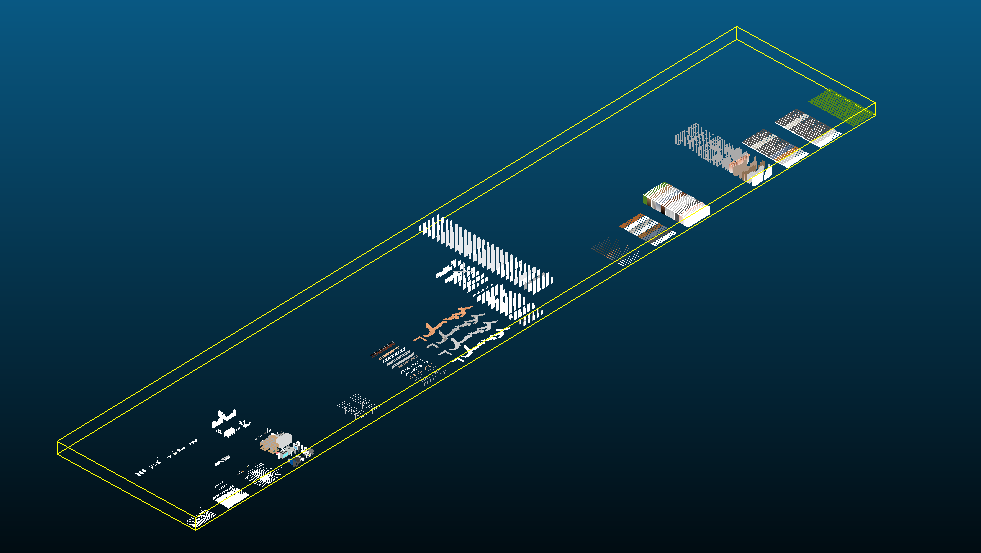

In [1]:
from IPython.display import Image, display
display(Image(filename='/home/sogilvy/library_raw.png'))

# Train/test/eval split for HBIM Library data.

This notebook outlines a method to split the library data in such a way that minimises the chances of the network learning "unhelpful" features while training upon it.

The approach does the following, relying on the fact that in the library file each mesh sub-category is non-overlapping:
1. each category's mesh file, containing all sub-meshes for that category, is chunked into cells of a specified width on the x-y plane
2. each of these is randomly assigned per-category on a weighted basis to three samples, for train, test and eval, at a 65%, 20%, and 15% weight respectively.
3. each is transformed such that roofs and ceilings are elevated (or else they will be indistinguishable from the floors, walkways, and grass paths - we want the network to take *something* away from the elevation information or else including these categories is borderline pointless).
4. the cells are then shuffled within each split
5. a seed cell is chosen, and we build up cells randomly in a spiral from the seed cell, translating subsequent cells in x and y as we go
6. the combined meshes can then be exported and saved, ready to be plugged into the pipeline

The library files still suffer from synthetic issues, most notably that the network cannot learn from typical adjacencies of each type of structure in the data, but this approach helps mitigate the following concerns that would otherwise happen in a more crude splitting of the data:
- the network may learn to rely on absolute x/y information, or relative x/y information between different elements if the network's radius of point localisation is high enough
- the network may come to believe that elements in the training have a higher adjacency than is the case in real data samples.

# NOTE FOR THE RAW .bin FILE!

The raw .bin file has the wrong name for the `13_OTHER` category, instead being called `13_MESH`. You can manually change this in Cloudcompare before running anything on the library .bin file.

In [2]:
import subprocess
import shutil
import logging
import sys
import random
import re
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

from pointcept.supplemental.preprocessing import *

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# This is a data handling class to convert the raw .bin files as necessary to .ply, apply 
# any necessary transformations, and persist them to a predictable location.
# It can then load these on subsequent runs.
p = ParametrixPreprocessor("library")
p.ensure_meshes(bin_file="/home/sogilvy/library.bin")
p.meshes

06:47:43 - INFO - Input .bin specified: /home/sogilvy/library.bin
06:47:43 - INFO - Label library already has extracted meshes.


{'1_WALL': TriangleMesh with 5520 points and 2760 triangles.,
 '2_FLOOR': TriangleMesh with 2400 points and 1200 triangles.,
 '3_ROOF': TriangleMesh with 1680 points and 840 triangles.,
 '4_CEILING': TriangleMesh with 3840 points and 1920 triangles.,
 '5_FOOTPATH': TriangleMesh with 2400 points and 1200 triangles.,
 '6_GRASS': TriangleMesh with 432 points and 216 triangles.,
 '7_COLUMN': TriangleMesh with 1293085 points and 1322308 triangles.,
 '8_DOOR': TriangleMesh with 1814196 points and 1726857 triangles.,
 '9_WINDOW': TriangleMesh with 58283 points and 39485 triangles.,
 '10_STAIR': TriangleMesh with 258034 points and 232800 triangles.,
 '11_RAILING': TriangleMesh with 401512 points and 346260 triangles.,
 '12_RWP': TriangleMesh with 490764 points and 522314 triangles.,
 '13_OTHER': TriangleMesh with 1037417 points and 812920 triangles.}

In [4]:
# This part splits the meshes into chunks and assigns them to train/test/eval splits.
cell_width = 2.5
category_cells = divide_all_categories_into_cells(p.meshes, cell_width)
transformed_category_cells = transform_cells(category_cells)
splits = split_all_categories(transformed_category_cells)

# This part recombines them, one per split.
random_seed = 9039501
processed_meshes = process_splits(splits, cell_width, seed=random_seed)

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


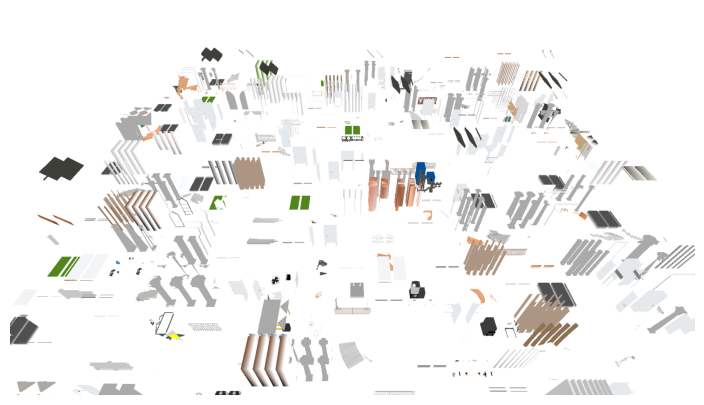

In [5]:
plot_mesh_inline(processed_meshes['train'])

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


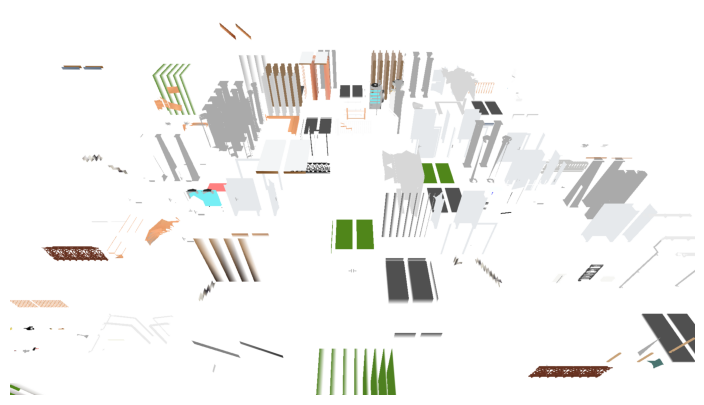

In [6]:
plot_mesh_inline(processed_meshes['test'])

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


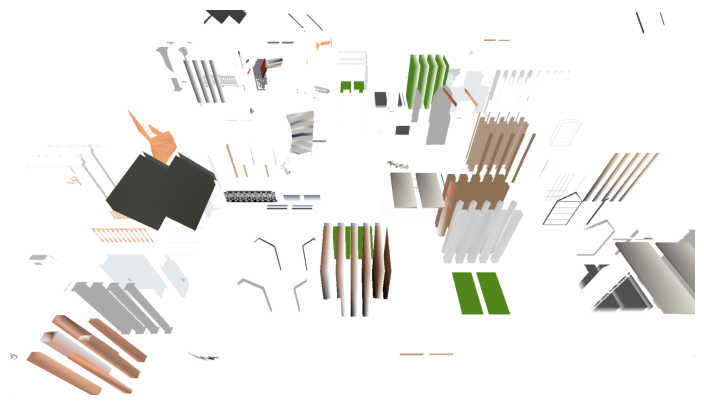

In [7]:
plot_mesh_inline(processed_meshes['eval'])